# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [5]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [6]:
#path = '~/scratch work/Yuqing-Data-Merge/Data/dt'

In [7]:
df= pd.read_csv('dff5.csv', parse_dates = True)
df = df[['ds', 'y', 'fbsp','diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs']]
df


,ds,y,fbsp,diff,tby,ffr,fta,eps,div,une,wti,ppi,rfs
0,2009-01-28,874.09,775.368737,98.721263,2.71,0.15,1927437.0,18.75,3.23,7.8,42.04,171.2,336929.0
1,2009-01-29,845.14,771.778314,73.361686,2.87,0.15,1927437.0,18.75,3.23,7.8,41.58,171.2,336929.0
2,2009-01-30,825.88,769.800284,56.079716,2.87,0.15,1927437.0,18.75,3.23,7.8,41.73,171.2,336929.0
3,2009-02-02,825.44,774.798116,50.641884,2.76,0.22,1927437.0,15.31,3.24,8.3,41.35,169.3,335576.0
4,2009-02-03,838.51,772.782361,65.727639,2.89,0.22,1927437.0,15.31,3.24,8.3,40.87,169.3,335576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,2020-02-21,3337.75,3176.089345,161.660655,1.46,1.58,4171570.0,135.28,1.79,3.5,53.36,196.7,525810.0
2762,2020-02-24,3225.89,3177.664932,48.225068,1.38,1.58,4171570.0,135.28,1.79,3.5,51.36,196.7,525810.0
2763,2020-02-25,3128.21,3179.642531,-51.432531,1.33,1.58,4171570.0,135.28,1.79,3.5,49.78,196.7,525810.0
2764,2020-02-26,3116.39,3181.017180,-64.627180,1.33,1.58,4158637.0,135.28,1.79,3.5,48.67,196.7,525810.0


In [8]:
p = 0.9
# Train around 90% of dataset 
cutoff = int((p*len(df)//100)*100)

df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()

In [9]:
df.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs'],
      dtype='object')

In [18]:
possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs']

from itertools import chain, combinations

def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


#print(list(powerset(possible_features)))

In [19]:
from statsmodels.regression.linear_model import OLS

reg_new = OLS((df_train['y'] - df_train.fbsp).copy(),df_train[possible_features].copy()).fit()
print(reg_new.params)

#from the output, we can see it's consistent with sklearn output

tby     -2.013665
ffr     21.833876
fta     -0.000091
eps     -7.317132
div   -188.444299
une    -50.725016
wti      3.777527
ppi      1.705641
rfs      0.002834
dtype: float64


In [20]:
new_coef = reg_new.params
new_possible_feats = new_coef[abs(new_coef)>0].index

power_feats = list(powerset(new_possible_feats))
power_feats.remove(())

power_feats = [ list(feats) for feats in power_feats]
power_feats 


[['tby'],
 ['ffr'],
 ['fta'],
 ['eps'],
 ['div'],
 ['une'],
 ['wti'],
 ['ppi'],
 ['rfs'],
 ['tby', 'ffr'],
 ['tby', 'fta'],
 ['tby', 'eps'],
 ['tby', 'div'],
 ['tby', 'une'],
 ['tby', 'wti'],
 ['tby', 'ppi'],
 ['tby', 'rfs'],
 ['ffr', 'fta'],
 ['ffr', 'eps'],
 ['ffr', 'div'],
 ['ffr', 'une'],
 ['ffr', 'wti'],
 ['ffr', 'ppi'],
 ['ffr', 'rfs'],
 ['fta', 'eps'],
 ['fta', 'div'],
 ['fta', 'une'],
 ['fta', 'wti'],
 ['fta', 'ppi'],
 ['fta', 'rfs'],
 ['eps', 'div'],
 ['eps', 'une'],
 ['eps', 'wti'],
 ['eps', 'ppi'],
 ['eps', 'rfs'],
 ['div', 'une'],
 ['div', 'wti'],
 ['div', 'ppi'],
 ['div', 'rfs'],
 ['une', 'wti'],
 ['une', 'ppi'],
 ['une', 'rfs'],
 ['wti', 'ppi'],
 ['wti', 'rfs'],
 ['ppi', 'rfs'],
 ['tby', 'ffr', 'fta'],
 ['tby', 'ffr', 'eps'],
 ['tby', 'ffr', 'div'],
 ['tby', 'ffr', 'une'],
 ['tby', 'ffr', 'wti'],
 ['tby', 'ffr', 'ppi'],
 ['tby', 'ffr', 'rfs'],
 ['tby', 'fta', 'eps'],
 ['tby', 'fta', 'div'],
 ['tby', 'fta', 'une'],
 ['tby', 'fta', 'wti'],
 ['tby', 'fta', 'ppi'],
 ['tby', '

In [21]:
AIC_scores = []
parameters = []

for feats in power_feats:
    tmp_reg = OLS((df_train['y'] - df_train.fbsp).copy(),df_train[feats].copy()).fit()
    AIC_scores.append(tmp_reg.aic)
    parameters.append(tmp_reg.params)

    
Min_AIC_index = AIC_scores.index(min(AIC_scores))
Min_AIC_feats = power_feats[Min_AIC_index]  
Min_AIC_params  = parameters[Min_AIC_index]
print(Min_AIC_feats)
print(Min_AIC_params)  

['ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi', 'rfs']
ffr     18.443320
fta     -0.000094
eps     -7.281444
div   -187.383864
une    -51.906509
wti      3.762585
ppi      1.704297
rfs      0.002861
dtype: float64


In [22]:
###After selecting the best features, we report the testing error, and make the plot 
AIC_df_test = df_test[Min_AIC_feats]
AIC_pred_test = AIC_df_test.dot(Min_AIC_params)+df_test.fbsp

AIC_df_train = df_train[Min_AIC_feats]
AIC_pred_train = AIC_df_train.dot(Min_AIC_params)+ df_train.fbsp



In [23]:
from sklearn.metrics import mean_squared_error as MSE

mse_train = MSE(df_train.y, AIC_pred_train) 
mse_test = MSE(df_test.y, AIC_pred_test)


#compare with fbprophet()

fb_mse_train = MSE(df_train.y, df_train.fbsp) 
fb_mse_test = MSE(df_test.y, df_test.fbsp)


print(mse_train,mse_test)

print(fb_mse_train,fb_mse_test)

8795.879439570397 68509.2540419534
18536.638305640623 30385.834822789413


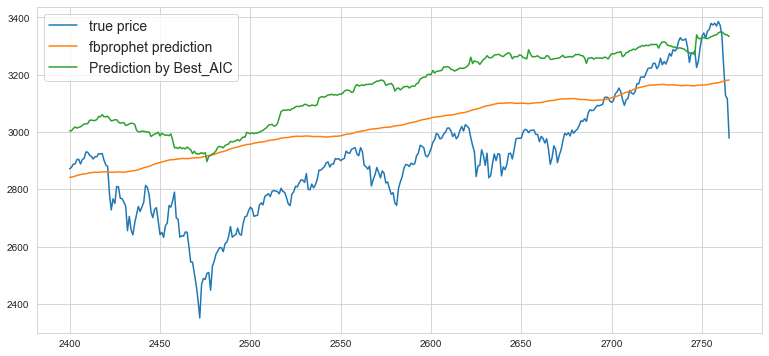

In [24]:
plt.figure(figsize=(13,6))
plt.plot(df_test.y,label="true price")
plt.plot(df_test.fbsp,label="fbprophet prediction")
plt.plot(AIC_pred_test,label="Prediction by Best_AIC")
plt.legend(fontsize = 14)
plt.show()